In [1]:
import numpy as np
import scipy.interpolate as scp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f2(x): return x * np.sin(np.pi / x)

## Interpolacja
Znajduję się tutaj tylko dla celów porównawczych

In [3]:
def cubic_interp1d(x0, x, y):
    x = np.asfarray(x)
    y = np.asfarray(y)

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    Li = np.empty(size)
    Li_1 = np.empty(size - 1)
    z = np.empty(size)

    Li[0] = np.sqrt(2 * xdiff[0])
    Li_1[0] = 0.0
    B0 = 0.0
    z[0] = B0 / Li[0]

    for i in range(1, size - 1, 1):
        Li_1[i] = xdiff[i - 1] / Li[i - 1]
        Li[i] = np.sqrt(2 * (xdiff[i - 1] + xdiff[i]) - Li_1[i - 1] * Li_1[i - 1])
        Bi = 6 * (ydiff[i] / xdiff[i] - ydiff[i - 1] / xdiff[i - 1])
        z[i] = (Bi - Li_1[i - 1] * z[i - 1]) / Li[i]

    i = size - 1
    Li_1[i - 1] = xdiff[-1] / Li[i - 1]
    Li[i] = np.sqrt(2 * xdiff[-1] - Li_1[i - 1] * Li_1[i - 1])
    Bi = 0.0
    z[i] = (Bi - Li_1[i - 1] * z[i - 1]) / Li[i]

    i = size - 1
    z[i] = z[i] / Li[i]
    for i in range(size - 2, -1, -1):
        z[i] = (z[i] - Li_1[i - 1] * z[i + 1]) / Li[i]

    index = x.searchsorted(x0)
    np.clip(index, 1, size - 1, index)

    xi1, xi0 = x[index], x[index - 1]
    yi1, yi0 = y[index], y[index - 1]
    zi1, zi0 = z[index], z[index - 1]
    hi1 = xi1 - xi0

    f0 = zi0 / (6 * hi1) * (xi1 - x0) ** 3 + zi1 / (6 * hi1) * (x0 - xi0) ** 3 + (yi1 / hi1 - zi1 * hi1 / 6) * (
            x0 - xi0) + (yi0 / hi1 - zi0 * hi1 / 6) * (xi1 - x0)
    return f0


## Aproksymacja
Tu pojawia się problem jak wybrać podział, jak zapewnić minimalny błąd i jednocześnie spełniać warunki na bycie splajnem. Na szczęście możemy wykorzystać do tego B-spline, które przejdą przez węzły początkowe jednocześnie aproksymująć pozostałe węzły.  
https://link.springer.com/article/10.1007%2FPL00007188

In [4]:
def bspline(points, n=100, degree=3):
    points = np.asarray(points)
    count = points.shape[0]
    degree = np.clip(degree,1,count-1)

    kv = np.concatenate((np.zeros(degree), np.arange(count-degree+1), np.ones(degree)*(count-degree)))
    u = np.linspace(0,(count-degree),n)

    return np.array(scp.splev(u, (kv,points.T,degree))).T

In [5]:
x = np.linspace(.1, 1, 501)
xa = np.linspace(.1, 1, 11)
y = f2(xa)
points = np.array(list(zip(xa,y)))

In [6]:
approx = bspline(points,200)

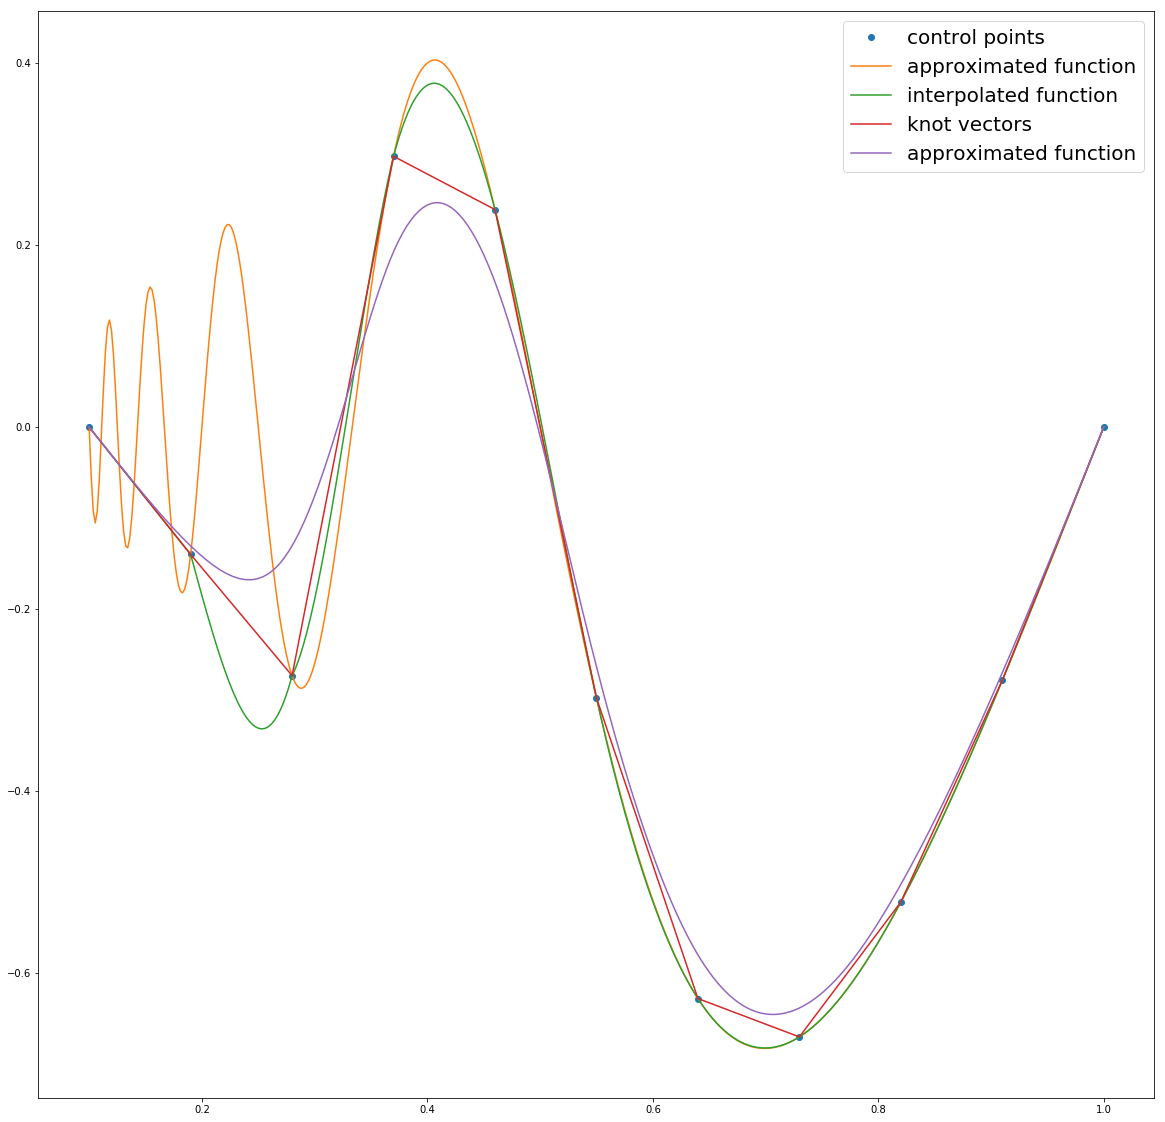

In [7]:
plt.figure(figsize=(20, 20))
plt.plot(xa, y, 'o',label='control points')
plt.plot(x,f2(x),label='approximated function')
plt.plot(x, cubic_interp1d(x, xa, y),label='interpolated function')
plt.plot(points[:,0],points[:,1],label='knot vectors')
plt.plot(approx[:,0],approx[:,1],label='approximated function')
l = plt.legend(loc='upper right',prop={'size': 20})
l.set_zorder(20)
plt.show()

## Wnioski
Dzięki B-spline'om uzyskujemy wszyskie cechy aproksymacji tj:  
- wygładzamy funkcję  
- upraszczamy funkcję zachowyjąc jej charakter  